# Time‑series Feature Engineering with scikit‑learn

## 0  Setup & Dataset

First, we will download the bike sharing demand dataset from OpenML and re-add the datetime feature. Concretely, we will convert the year, month and weekday and hour into a timedate object, that stores both the date and timestamp of an observation. We perform this conversion as the datetime feature is the most natural representation of date in a time series.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml

bike, target = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, return_X_y=True)
year = bike["year"]
year.iloc[year == 0] = 2011
year.iloc[year == 1] = 2012
bike["year"] = year

current_month = -1
current_weekday = -1
current_day = 1
days = []
for idx, row in bike.iterrows():
    if row["month"] != current_month:
        current_day = 1
        current_weekday = row["weekday"]
        current_month = row["month"]
    if row["weekday"] != current_weekday:
        current_day += 1
        current_weekday = row["weekday"]
    days.append(current_day)
bike["days"] = days
    
bike["datetime"] = pd.to_datetime(bike[["year", "month", "hour", "days"]])
bike["count"] = target

bike["datetime"] = pd.to_datetime(bike["datetime"])
bike = bike.sort_values("datetime").reset_index(drop=True)

# Now that we have datetime, let's drop the other time features
bike = bike.drop(["season", "year", "month", "hour", "weekday", "days"], axis=1)

bike.head()

/tmp/ipykernel_717693/2022699457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year.iloc[year == 1] = 2012


,holiday,workingday,weather,temp,feel_temp,humidity,windspeed,datetime,count
0,False,False,clear,9.84,14.395,0.81,0.0,2011-01-01 00:00:00,16
1,False,False,clear,9.02,13.635,0.80,0.0,2011-01-01 01:00:00,40
2,False,False,clear,9.02,13.635,0.80,0.0,2011-01-01 02:00:00,32
3,False,False,clear,9.84,14.395,0.75,0.0,2011-01-01 03:00:00,13
4,False,False,clear,9.84,14.395,0.75,0.0,2011-01-01 04:00:00,1


## Exercise 0.1

Let's also plot the first ten days of data

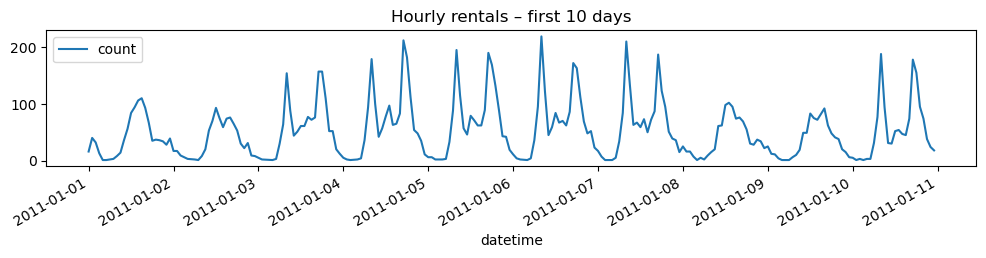

In [2]:
#===SOLUTION===
mask = (bike["datetime"] < bike["datetime"].min() + pd.Timedelta(days=10))
bike.loc[mask, ["datetime", "count"]].set_index("datetime").plot(figsize=(12,2))
plt.title("Hourly rentals – first 10 days");

## Exercise 0.2

And also inspect the data types

In [73]:
#===SOLUTION===
bike.dtypes

holiday             category
workingday          category
weather             category
temp                 float64
feel_temp            float64
humidity             float64
windspeed            float64
datetime      datetime64[ns]
count                  int64
dtype: object

## 1  Exploratory Analysis

Create at least two plots that help you understand the data distribution. For example, the average amount of rentals for every hour of the day, or the average amount of rentals for every weekday.

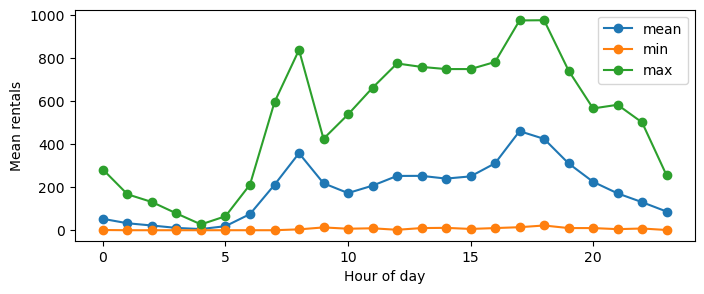

In [75]:
#===SOLUTION===
# Mean rentals by hour
bike.groupby(bike["datetime"].dt.hour)["count"].mean().plot(kind="line", marker="o", figsize=(8,3), label="mean")
bike.groupby(bike["datetime"].dt.hour)["count"].min().plot(kind="line", marker="o", figsize=(8,3), label="min")
bike.groupby(bike["datetime"].dt.hour)["count"].max().plot(kind="line", marker="o", figsize=(8,3), label="max")
plt.ylabel("Mean rentals")
plt.xlabel("Hour of day")
plt.legend()

Text(0.5, 0, 'Weekday')

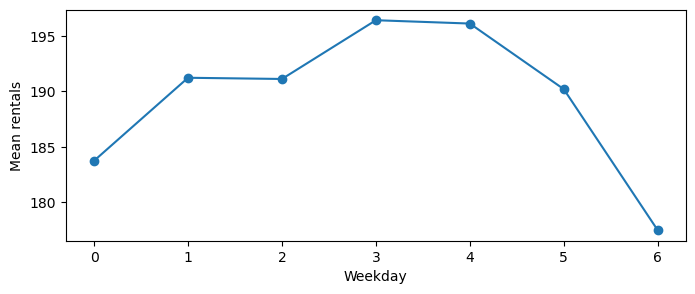

In [76]:
#===SOLUTION===
bike.groupby(bike["datetime"].dt.dayofweek)["count"].mean().plot(kind="line", marker="o", figsize=(8,3))
plt.ylabel("Mean rentals")
plt.xlabel("Weekday")

## 2  Calendar & Cyclic Feature Transformer

Write two function that take a dataframe containing the column `"datetime"` and that add the following features:
1. Function one - absolute datetime indicator features
    1. hour
    2. day of the week
    3. day of the month
    4. month
2. Function two - cyclic features
    1. hour as cyclic features
    2. day of the week as cyclic features
    3. day of the month as cyclic feature
    4. month as cyclic feature
Then, wrap these function in a `FunctionTransformer` to make them accessible as scikit-learn objects

In [6]:
#===SOLUTION===
from sklearn.preprocessing import FunctionTransformer

def add_calendar_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    dt = X["datetime"]
    X["hour"]       = dt.dt.hour
    X["dow"]        = dt.dt.dayofweek
    X["dom"]        = dt.dt.day
    X["month"]      = dt.dt.month
    return X

def add_cyclic_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    dt = X["datetime"]
    X["hour_sin"] = np.sin(2 * np.pi * dt.dt.hour / 24)
    X["hour_cos"] = np.cos(2 * np.pi * dt.dt.hour / 24)
    X["dow_sin"]  = np.sin(2 * np.pi * dt.dt.dayofweek  / 7)
    X["dow_cos"]  = np.cos(2 * np.pi * dt.dt.dayofweek  / 7)
    X["month_sin"]  = np.sin(2 * np.pi * dt.dt.month  / 12)
    X["month_cos"]  = np.cos(2 * np.pi * dt.dt.month  / 12)
    return X

cal_tf = FunctionTransformer(add_calendar_features)
cyc_tf = FunctionTransformer(add_cyclic_features)

In [7]:
#===SOLUTION===
# Quick smoke‑test:

sample = bike.head(3)
print(cal_tf.transform(sample).head(2))

  holiday workingday weather  temp  feel_temp  humidity  windspeed  \
0   False      False   clear  9.84     14.395      0.81        0.0   
1   False      False   clear  9.02     13.635      0.80        0.0   

             datetime  count  hour  dow  dom  month  
0 2011-01-01 00:00:00     16     0    5    1      1  
1 2011-01-01 01:00:00     40     1    5    1      1  


In [15]:
#===SOLUTION===
cyc_tf.transform(cal_tf.transform(sample)).dtypes

holiday             category
workingday          category
weather             category
temp                 float64
feel_temp            float64
humidity             float64
windspeed            float64
datetime      datetime64[ns]
count                  int64
hour                   int32
dow                    int32
dom                    int32
month                  int32
hour_sin             float64
hour_cos             float64
dow_sin              float64
dow_cos              float64
month_sin            float64
month_cos            float64
dtype: object

## 3. Building pipelines

Construct four machine learning pipelines that use the above transformations and compare them against simple baselines:
1. Use both transformations
2. Use only the cyclic features
3. Use only the calendar features
4. Use none of the above transformations and ignore the date information

Hint: make sure to not pass the `"datetime"` feature to the machine learning model

In [80]:
#===SOLUTION===
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

preproc = ColumnTransformer([
    ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include="category"))
], remainder="drop")

model = HistGradientBoostingRegressor(
    max_depth=7, 
    learning_rate=0.01, 
    l2_regularization=0.0, 
    random_state=0,
    n_iter_no_change=20,
    max_iter=1000,
)

calender_only = Pipeline([
    ("calendar", cal_tf),
    ("prep", preproc),
    ("model", model)
 ])

cyclic_only = Pipeline([
    ("cyclic", cyc_tf),
    ("prep", preproc),
    ("model", model)
 ])

calendar_and_cyclic = Pipeline([
    ("calendar", cal_tf),
    ("cyclic", cyc_tf),
    ("prep", preproc),
    ("model", model)
 ])

simple_pipe = Pipeline([
    ("prep", preproc),
    ("model", model)
])

#print(f"Final feature count: {len(preproc.get_feature_names_out())}")

## 4. Time series cross-validation

Use scikit-learn's time series cross-validation feature to evaluate the four different pipelines. Use a test set of one week of data to evaluate the models. In order to better understand how the time series cross-validation partitions the data, you can print the size of the training and the test splits.

In [79]:
#===SOLUTION===
# Let's first validate that we do not fit on the datetime feature
X = bike.drop("count", axis=1)
y = bike["count"]
pipe.fit(X, y)
print(pipe.steps[-1][-1].feature_names_in_)
print("datetime" in pipe.steps[-1][-1].feature_names_in_)

['num__temp' 'num__feel_temp' 'num__humidity' 'num__windspeed' 'num__hour'
 'num__dow' 'num__dom' 'num__month' 'num__hour_sin' 'num__hour_cos'
 'num__dow_sin' 'num__dow_cos' 'num__month_sin' 'num__month_cos'
 'cat__holiday_False' 'cat__holiday_True' 'cat__workingday_False'
 'cat__workingday_True' 'cat__weather_clear' 'cat__weather_heavy_rain'
 'cat__weather_misty' 'cat__weather_rain']
False


14019 168
14187 168
14355 168
14523 168
14691 168
14859 168
15027 168
15195 168
15363 168
15531 168
15699 168
15867 168
16035 168
16203 168
16371 168
16539 168
16707 168
16875 168
17043 168
17211 168


Text(0.5, 1.0, 'TimeSeriesSplit')

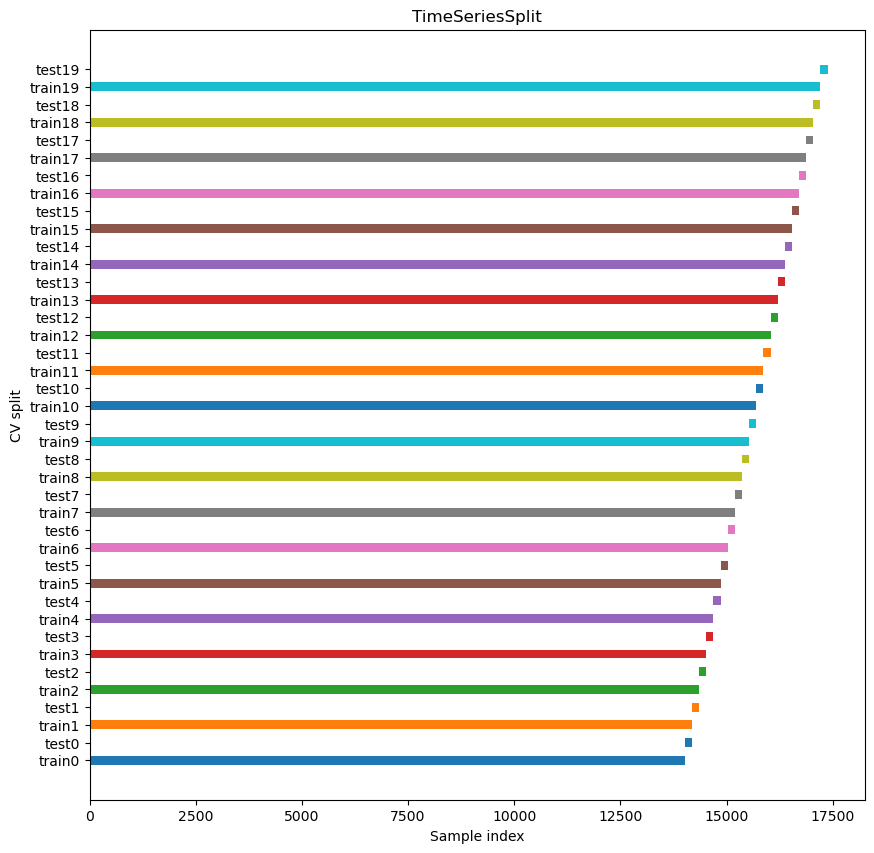

In [84]:
#===SOLUTION===
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=20, test_size=24*7)  # 1‑week horizon

# Let's now visualize the actual splits
fig, ax = plt.subplots(figsize=(10, 10))
for i, (train, test) in enumerate(tscv.split(X)):
    labels = [f"train{i}", f"test{i}"]
    widths = [len(train), len(test)]
    print(len(train), len(test))
    starts = [0, len(train)]
    rects = ax.barh(labels, widths, left=starts, height=0.5, label=i,)
_ = ax.set_xlabel("Sample index"); ax.set_ylabel("CV split"); ax.set_title("TimeSeriesSplit")

In [85]:
#===SOLUTION===
for name, pipeline in (
    ("Simple baseline", simple_pipe),
    ("Calendar features", calender_only),
    ("Cyclic features", cyclic_only),
    ("Calendar and cyclic features", calendar_and_cyclic)
    
):
    rmse = -cross_val_score(
        pipeline,
        X=X,
        y=y,
        cv=tscv, 
        scoring="neg_root_mean_squared_error", 
        n_jobs=-2,
    )
    print(name)
    print("Fold RMSE:", rmse.round(2))
    print(f"Mean ± SD: {rmse.mean():.2f} ± {rmse.std():.2f}")

Simple baseline
Fold RMSE: [194.13 204.14 197.47 209.18 227.54 222.05 237.75 231.42 225.91 226.2
 246.34 184.26 187.92 178.97 127.06 197.59 197.06 179.06 128.    62.08]
Mean ± SD: 193.21 ± 43.13
Calendar features
Fold RMSE: [117.84 101.01 102.5  119.85 132.92 105.71 103.75 135.45 142.53 123.53
 104.33 116.25 109.26  97.34  84.48 110.67 104.65  85.14  66.02  52.97]
Mean ± SD: 105.81 ± 21.37
Cyclic features
Fold RMSE: [107.69  95.81  91.36 118.01 139.97  98.8   88.59 130.02 146.8  114.64
 103.84 120.41 121.35  79.28  81.03 107.81 116.97  94.13  75.34  68.87]
Mean ± SD: 105.04 ± 20.79
Calendar and cyclic features
Fold RMSE: [114.62 101.15 103.38 119.56 138.39 104.56  98.54 130.87 144.59 126.04
 113.5  114.85 111.08  93.48  77.16 113.9  107.23  88.36  65.78  53.45]
Mean ± SD: 106.03 ± 22.14


## 5  Lagged & Rolling Feature Transformers

In the next step, the goal is to use lagged and rolling features. Since these are hard to integrate into the pipeline structure, we have to iterate over the splits ourselves, generate the features, and only then go into the pipelines. For each fold, create a 1 week, 2 week, 3 week and 4 week lag feature (since we are predicting for a one-week time horizon) and the last week rental average and standard deviation. Make sure that there is no data leakage, i.e., the model is not trained on any test data at all.

In [108]:
#===SOLUTION===
from collections import defaultdict

test_set_size = 24 * 7  # 1‑week horizon
tscv = TimeSeriesSplit(n_splits=5, test_size=test_set_size)

all_rmses = defaultdict(list)

for i, (train, test) in enumerate(tscv.split(bike["count"])):
    bike_ = bike.copy()
    for lag in (test_set_size, test_set_size * 2, test_set_size * 3, test_set_size * 4):
        bike_[f"lag{lag}"] = bike_["count"].shift(lag)
    bike_[f"roll{test_set_size}_mean"] = bike_["count"].shift(test_set_size).rolling(test_set_size).mean()
    bike_[f"roll{test_set_size}_std"] = bike_["count"].shift(test_set_size).rolling(test_set_size).std()

    X_train = bike_.iloc[train].drop("count", axis=1)
    X_test = bike_.iloc[test].drop("count", axis=1)
    y_train = bike_.iloc[train]["count"]
    y_test = bike_.iloc[test]["count"]

    for name, pipeline in (
        ("Simple baseline", simple_pipe),
        ("Calendar features", calender_only),
        ("Cyclic features", cyclic_only),
        ("Calendar and cyclic features", calendar_and_cyclic)
    ):
        print(name, i, len(train))
        pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict(X_test)
        rmse = sklearn.metrics.root_mean_squared_error(y_test, y_hat)
        print("Fold RMSE:", np.round(rmse, 3))
        all_rmses[name].append(rmse)

for key, value in all_rmses.items():
    print(key, np.mean(value))
        

Simple baseline 0 16539
Fold RMSE: 133.833
Calendar features 0 16539
Fold RMSE: 96.954
Cyclic features 0 16539
Fold RMSE: 89.82
Calendar and cyclic features 0 16539
Fold RMSE: 91.648
Simple baseline 1 16707
Fold RMSE: 97.457
Calendar features 1 16707
Fold RMSE: 80.863
Cyclic features 1 16707
Fold RMSE: 79.689
Calendar and cyclic features 1 16707
Fold RMSE: 78.848
Simple baseline 2 16875
Fold RMSE: 62.008
Calendar features 2 16875
Fold RMSE: 41.558
Cyclic features 2 16875
Fold RMSE: 38.456
Calendar and cyclic features 2 16875
Fold RMSE: 38.306
Simple baseline 3 17043
Fold RMSE: 90.358
Calendar features 3 17043
Fold RMSE: 73.556
Cyclic features 3 17043
Fold RMSE: 91.437
Calendar and cyclic features 3 17043
Fold RMSE: 72.42
Simple baseline 4 17211
Fold RMSE: 85.723
Calendar features 4 17211
Fold RMSE: 59.493
Cyclic features 4 17211
Fold RMSE: 83.316
Calendar and cyclic features 4 17211
Fold RMSE: 71.297
Simple baseline 93.87572885017866
Calendar features 70.48471724272065
Cyclic features 